In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 6205 (delta 1), reused 3 (delta 1), pack-reused 6196
Receiving objects: 100% (6205/6205), 13.48 MiB | 29.49 MiB/s, done.
Resolving deltas: 100% (4196/4196), done.


In [ ]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl size=168078 sha256=9803c7e3886a98de06db305eb627053f804fa5b4c48cb6680ca99d5336315b41
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=28de3fc30d80df6e0dce5a95c1d9f8ac20e65608878d84a8076872414aca7bee
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [ ]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import urllib
import os
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

In [ ]:
urllib.request.urlretrieve(
    'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5',
    'pretrained_model.h5')

('pretrained_model.h5', <http.client.HTTPMessage at 0x7f5b281396d8>)

In [ ]:
model = models.load_model('pretrained_model.h5')

In [ ]:
!wget https://lazyprogrammer.me/course_files/obj_detection/coco_categories.txt
class_names = [l.rstrip() for l in open('coco_categories.txt')]
class_names

--2020-10-11 19:51:52--  https://lazyprogrammer.me/course_files/obj_detection/coco_categories.txt
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 172.67.213.166, 104.31.81.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘coco_categories.txt.1’

coco_categories.txt     [ <=>                ]     621  --.-KB/s    in 0s      

2020-10-11 19:51:53 (15.6 MB/s) - ‘coco_categories.txt.1’ saved [621]



['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [ ]:
def show_image_with_predictions(img_path, threshold=0.6):
  im = np.array(Image.open(img_path))
  print("im.shape:", im.shape)

  # if there's a PNG it will have alpha channel
  im = im[:,:,:3]
  
  ### plot predictions ###

  # get predictions
  imp = preprocess_image(im)
  imp, scale = resize_image(im)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(imp, axis=0)
  )

  # standardize box coordinates
  boxes /= scale

  # loop through each prediction for the input image
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can quit as soon
    # as we see a score below threshold
    if score < threshold:
      break

    box = box.astype(np.int32)
    color = label_color(label)
    draw_box(im, box, color=color)

    class_name = class_names[label]
    caption = f"{class_name} {score:.3f}"
    draw_caption(im, box, caption)

  plt.axis('off')
  plt.imshow(im)
  plt.show()


In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]

im.shape: (1872, 1248, 3)


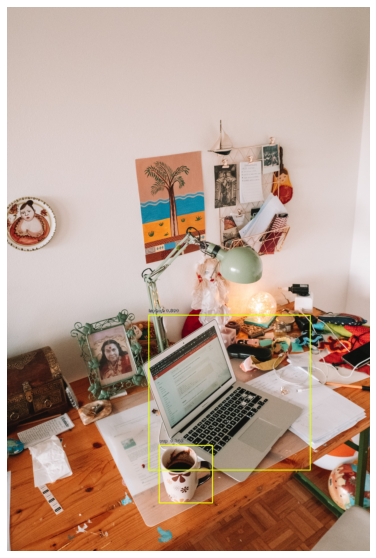

In [ ]:
show_image_with_predictions('../desk2.jpg')